### Using tf.data for Multiple Files

In [51]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt
import numpy as np
import pickle
from tensorflow.keras import utils as np_utils

from sklearn.preprocessing import MinMaxScaler
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs

SHUFFLE_BUFFER = 500
BATCH_SIZE = 128

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.5.0
Eager execution: True


In [53]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x7f4f5730fbf8>

print(tf.test.gpu_device_name())
# /device:GPU:0

print(tf.config.get_visible_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000021E44735430>
/device:GPU:0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
df = pd.read_csv("edit_fixtures_raw_players.csv",encoding='latin-1')

In [55]:
CATEGORIES = ['HOME', 'AWAY', 'DRAW'] # 0 = home, 0.5 = draw, 1 = away


In [56]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [57]:
df.head()

,fixture_id,home_id,h_elo,h_attack,h_defence,away_id,a_elo,a_attack,a_defence,result,h_Shots_on_Goal,h_Shots_off_Goal,h_Total_Shots,h_Blocked_Shots,h_Shots_insidebox,h_Shots_outsidebox,h_Fouls,h_Corner_Kicks,h_Ball_Possession,h_Goalkeeper_Saves,h_Total_passes,h_Passes_accurate,h_Passing_accuracy,a_Shots_on_Goal,a_Shots_off_Goal,a_Total_Shots,a_Blocked_Shots,a_Shots_insidebox,a_Shots_outsidebox,a_Fouls,a_Corner_Kicks,a_Ball_Possession,a_Goalkeeper_Saves,a_Total_passes,a_Passes_accurate,a_Passing_accuracy,h_p0_player_id,h_p0_minutes,h_p0_number,h_p0_rating,h_p0_offside,h_p0_total_shots,h_p0_on_goal_shots,h_p0_total_goals,h_p0_conceded,h_p0_assists,h_p0_saves,h_p0_total_passes,h_p0_key_passes,h_p0_pass_accuracy,h_p0_total_tackels,h_p0_blocks,h_p0_interceptions,h_p0_total_duels,h_p0_won_duels,h_p0_dribble_attempts,h_p0_dribble_success,h_p0_dribble_past,h_p0_drawn_fouls,h_p0_commited_fouls,h_p0_yellow,h_p0_red,h_p0_won_penalty,h_p0_commited_penalty,h_p0_scored_penalty,h_p0_missed_penalty,h_p0_saved_penalty,h_p1_player_id,h_p1_minutes,h_p1_number,h_p1_rating,h_p1_offside,h_p1_total_shots,h_p1_on_goal_shots,h_p1_total_goals,h_p1_conceded,h_p1_assists,h_p1_saves,h_p1_total_passes,h_p1_key_passes,h_p1_pass_accuracy,h_p1_total_tackels,h_p1_blocks,h_p1_interceptions,h_p1_total_duels,h_p1_won_duels,h_p1_dribble_attempts,h_p1_dribble_success,h_p1_dribble_past,h_p1_drawn_fouls,h_p1_commited_fouls,h_p1_yellow,h_p1_red,h_p1_won_penalty,h_p1_commited_penalty,h_p1_scored_penalty,h_p1_missed_penalty,h_p1_saved_penalty,h_p2_player_id,h_p2_minutes,h_p2_number,h_p2_rating,h_p2_offside,h_p2_total_shots,h_p2_on_goal_shots,h_p2_total_goals,h_p2_conceded,h_p2_assists,h_p2_saves,h_p2_total_passes,h_p2_key_passes,h_p2_pass_accuracy,h_p2_total_tackels,h_p2_blocks,h_p2_interceptions,h_p2_total_duels,h_p2_won_duels,h_p2_dribble_attempts,h_p2_dribble_success,h_p2_dribble_past,h_p2_drawn_fouls,h_p2_commited_fouls,h_p2_yellow,h_p2_red,h_p2_won_penalty,h_p2_commited_penalty,h_p2_scored_penalty,h_p2_missed_penalty,h_p2_saved_penalty,h_p3_player_id,h_p3_minutes,h_p3_number,h_p3_rating,h_p3_offside,h_p3_total_shots,h_p3_on_goal_shots,h_p3_total_goals,h_p3_conceded,h_p3_assists,h_p3_saves,h_p3_total_passes,h_p3_key_passes,h_p3_pass_accuracy,h_p3_total_tackels,h_p3_blocks,h_p3_interceptions,h_p3_total_duels,h_p3_won_duels,h_p3_dribble_attempts,h_p3_dribble_success,h_p3_dribble_past,h_p3_drawn_fouls,h_p3_commited_fouls,h_p3_yellow,h_p3_red,h_p3_won_penalty,h_p3_commited_penalty,h_p3_scored_penalty,h_p3_missed_penalty,h_p3_saved_penalty,h_p4_player_id,h_p4_minutes,h_p4_number,h_p4_rating,h_p4_offside,h_p4_total_shots,h_p4_on_goal_shots,h_p4_total_goals,h_p4_conceded,h_p4_assists,h_p4_saves,h_p4_total_passes,h_p4_key_passes,h_p4_pass_accuracy,h_p4_total_tackels,h_p4_blocks,h_p4_interceptions,h_p4_total_duels,h_p4_won_duels,h_p4_dribble_attempts,h_p4_dribble_success,h_p4_dribble_past,h_p4_drawn_fouls,h_p4_commited_fouls,h_p4_yellow,h_p4_red,h_p4_won_penalty,h_p4_commited_penalty,h_p4_scored_penalty,h_p4_missed_penalty,h_p4_saved_penalty,h_p5_player_id,h_p5_minutes,h_p5_number,h_p5_rating,h_p5_offside,h_p5_total_shots,h_p5_on_goal_shots,h_p5_total_goals,h_p5_conceded,h_p5_assists,h_p5_saves,h_p5_total_passes,h_p5_key_passes,h_p5_pass_accuracy,h_p5_total_tackels,h_p5_blocks,h_p5_interceptions,h_p5_total_duels,h_p5_won_duels,h_p5_dribble_attempts,h_p5_dribble_success,h_p5_dribble_past,h_p5_drawn_fouls,h_p5_commited_fouls,h_p5_yellow,h_p5_red,h_p5_won_penalty,h_p5_commited_penalty,h_p5_scored_penalty,h_p5_missed_penalty,h_p5_saved_penalty,h_p6_player_id,h_p6_minutes,h_p6_number,h_p6_rating,h_p6_offside,h_p6_total_shots,h_p6_on_goal_shots,h_p6_total_goals,h_p6_conceded,h_p6_assists,h_p6_saves,h_p6_total_passes,h_p6_key_passes,h_p6_pass_accuracy,h_p6_total_tackels,h_p6_blocks,h_p6_interceptions,h_p6_total_duels,h_p6_won_duels,h_p6_dribble_attempts,h_p6_dribble_success,h_p6_dribble_past,h_p6_drawn_fouls,h_p6_commited_fouls,h_p6_yellow,h_p6_red,h_p6_won_penalty,h_p6_commited_pe

In [ ]:
df.dtypes

In [59]:
target = df.pop('result')
target.head()


0    0.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: result, dtype: float64

In [14]:
target.value_counts()


0.0    6490
1.0    4458
0.5    3723
Name: result, dtype: int64

In [60]:
home = []
away = []
draw = []
for i in range(len(target)):
    if (target[i]==0.0):
        home.append(target[i])
    elif (target[i]==1.0):
        away.append(target[i])
    elif (target[i]==0.5):
        target[i]=2.0
        draw.append(target[i])
        
print(len(home))
print(len(away))
print(len(draw))
#for i in range(len(draw)):
    #print(draw[i])

C:\Users\Anwender\AppData\Local\Temp/ipykernel_19532/865394395.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[i]=2.0


6490
4458
3723


In [61]:
tf.convert_to_tensor(df)

<tf.Tensor: shape=(14671, 717), dtype=float64, numpy=
array([[6.50e+01, 3.30e+01, 1.70e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [6.60e+01, 3.40e+01, 1.48e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [6.70e+01, 3.50e+01, 1.48e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [7.06e+05, 1.91e+02, 1.51e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [7.06e+05, 2.40e+02, 1.42e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [7.06e+05, 2.26e+02, 1.48e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])>

In [17]:
#normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
#normalizer.adapt(df)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [18]:
#normalizer(df.iloc[:3])


In [19]:
x_train, x_val, y_train, y_val = train_test_split(df, target, test_size = 0.4, random_state=42)

In [71]:
print(len(x_train))
display(x_train)
print(y_val.value_counts())

8802


array([[0.29, 0.15, 0.34, ...,  nan,  nan,  nan],
       [0.03, 0.14, 0.16, ..., 0.  , 0.  , 0.  ],
       [0.22, 0.04, 0.56, ..., 0.2 , 0.  , 0.  ],
       ...,
       [0.03, 0.15, 0.27, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.13, 0.57, ..., 0.  , 0.  , 0.  ],
       [0.13, 0.05, 0.28, ..., 0.  , 0.  , 0.  ]])

0.0    1287
1.0     888
2.0     759
Name: result, dtype: int64


In [21]:
print(len(y_train))
print(y_train.value_counts())

8802
0.0    3919
1.0    2686
2.0    2197
Name: result, dtype: int64


In [22]:
print(len(x_val))
print(len(y_val))

5869
5869


In [23]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state=42)

In [ ]:
dummy_y = np_utils.to_categorical(y_train)
print(dummy_y[:100])
# 0 = home = 100, 1 = away = 010, 2 = draw =001

In [21]:
len(x_val)

2934

In [22]:
len(y_val)

2934

In [23]:
print(len(x_test))
print(len(y_test))

2935
2935


In [25]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    
        print(i)
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(3, activation="softmax")) #hier sigmoid statt softmax aus tutprial da binary und anzahl Klassen anstatt 10
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy", # https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
        metrics=["accuracy"],
    )
    return model


build_model(kt.HyperParameters())

0


In [26]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=200,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir_edit_fixtures_raw_players",
    project_name="helloworld_raw_players",
)

0


In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [27]:
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Trial 200 Complete [00h 00m 31s]
val_accuracy: 0.43865031003952026

Best val_accuracy So Far: 0.43865031003952026
Total elapsed time: 02h 02m 52s
INFO:tensorflow:Oracle triggered exit


In [28]:
tuner.results_summary()

Results summary
Results in my_dir_edit_fixtures_raw_players\helloworld_raw_players
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 4
units_0: 192
activation: relu
dropout: False
lr: 0.009075161336137299
units_1: 32
units_2: 32
units_3: 32
Score: 0.43865031003952026
Trial summary
Hyperparameters:
num_layers: 1
units_0: 128
activation: relu
dropout: False
lr: 0.0025202609860218053
units_1: 192
units_2: 32
units_3: 192
Score: 0.43865031003952026
Trial summary
Hyperparameters:
num_layers: 1
units_0: 64
activation: relu
dropout: True
lr: 0.0019076564245303202
units_1: 96
units_2: 160
units_3: 64
Score: 0.43865031003952026
Trial summary
Hyperparameters:
num_layers: 4
units_0: 224
activation: tanh
dropout: True
lr: 0.0018956752062350565
units_1: 32
units_2: 96
units_3: 32
Score: 0.43865031003952026
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
activation: relu
dropout: False
lr: 0.0021482173007602526
units_1: 32
uni

In [ ]:
hp = kt.HyperParameters()
learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#print(best_hps)
best_model = tuner.get_best_models(num_models=1)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=best_model)
#tf.train.Checkpoint.restore(...).expect_partial()
#to_be_predicted = np.array([[[0.6579319133419915,1666.6615077675299,0.18500000000000003,-0.37750000000000006,0,6.795720454545455,0.4803987065096406,1653.0341501069572,0.18500000000000003,-0.6725000000000001,0,6.8410482]]])
y_prob = best_model[0].predict(x_train)
#best_model[0].summary()


In [30]:
best_model[0].save('best_model_raw_players')

INFO:tensorflow:Assets written to: best_model_raw_players\assets


In [31]:
file_to_store = open("stored_object.pickle", "wb")
pickle.dump(tuner, file_to_store)

file_to_store.close()

In [29]:
file_to_read = open("stored_object.pickle", "rb")


loaded_tuner = pickle.load(file_to_read)


file_to_read.close()
print(loaded_tuner)

In [30]:
loaded_tuner.results_summary()

Results summary
Results in my_dir_raw\helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')


In [32]:
loaded_model = keras.models.load_model('best_model_raw_players')

In [33]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 717)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               137856    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6176      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 146,243
Trainable params: 146,243
Non-trainable params: 0
__________________________________________________

In [50]:
correct_prediction = 0
y_true = []
y_pred = []
false_prediction = 0
for i in range(len(x_test)):
   
    to_be_predicted = np.array([x_test[[i]]])
    y_prob = loaded_model.predict(to_be_predicted)
    
    result = y_test.iloc[[i][0]]
    predicted_result = np.argmax(y_prob) # wähle result mit 
    y_true.append(result)
    y_pred.append(predicted_result)
    
    if(int(result) == predicted_result):
        print(f"Match {i}")
        print("result: " + str(CATEGORIES[int(result)]))
        print("prediction: " + str(CATEGORIES[predicted_result]))
        correct_prediction = correct_prediction+1
    #print(y_prob[0][0])
    #print(y_prob[0][1])
    #print(y_prob[0][2])
    #print(f"result number {i}: " + str(y_val.iloc[[i][0]]))
    else:
        print(f"No Match: {i}")
        print("result: " + str(CATEGORIES[int(result)]))
    #print("prediction number "+ str(np.argmax(y_prob)))
        print("prediction: " + str(CATEGORIES[predicted_result]))
        false_prediction = false_prediction+1
print("correct: "+ str(correct_prediction) + "/" + str(len(x_test)))
print("correct: " +str(correct_prediction/len(x_test)))
print("false: "+ str(false_prediction) + "/" + str(len(x_test)))
print("false: " +str(false_prediction/len(x_test)))

Match 0
result: HOME
prediction: HOME
No Match: 1
result: DRAW
prediction: HOME
No Match: 2
result: AWAY
prediction: HOME
No Match: 3
result: DRAW
prediction: HOME
No Match: 4
result: DRAW
prediction: HOME
No Match: 5
result: DRAW
prediction: HOME
No Match: 6
result: DRAW
prediction: HOME
Match 7
result: HOME
prediction: HOME
No Match: 8
result: DRAW
prediction: HOME
No Match: 9
result: DRAW
prediction: HOME
No Match: 10
result: AWAY
prediction: HOME
Match 11
result: HOME
prediction: HOME
Match 12
result: HOME
prediction: HOME
No Match: 13
result: DRAW
prediction: HOME
No Match: 14
result: AWAY
prediction: HOME
No Match: 15
result: AWAY
prediction: HOME
Match 16
result: HOME
prediction: HOME
Match 17
result: HOME
prediction: HOME
Match 18
result: HOME
prediction: HOME
No Match: 19
result: DRAW
prediction: HOME
No Match: 20
result: AWAY
prediction: HOME
Match 21
result: HOME
prediction: HOME
Match 22
result: HOME
prediction: HOME
Match 23
result: HOME
prediction: HOME
No Match: 24
resul

Match 200
result: HOME
prediction: HOME
Match 201
result: HOME
prediction: HOME
Match 202
result: HOME
prediction: HOME
No Match: 203
result: DRAW
prediction: HOME
Match 204
result: HOME
prediction: HOME
No Match: 205
result: DRAW
prediction: HOME
No Match: 206
result: DRAW
prediction: HOME
No Match: 207
result: DRAW
prediction: HOME
No Match: 208
result: AWAY
prediction: HOME
No Match: 209
result: AWAY
prediction: HOME
No Match: 210
result: DRAW
prediction: HOME
No Match: 211
result: AWAY
prediction: HOME
No Match: 212
result: DRAW
prediction: HOME
No Match: 213
result: DRAW
prediction: HOME
Match 214
result: HOME
prediction: HOME
Match 215
result: HOME
prediction: HOME
Match 216
result: HOME
prediction: HOME
No Match: 217
result: AWAY
prediction: HOME
No Match: 218
result: AWAY
prediction: HOME
Match 219
result: HOME
prediction: HOME
Match 220
result: HOME
prediction: HOME
No Match: 221
result: AWAY
prediction: HOME
Match 222
result: HOME
prediction: HOME
Match 223
result: HOME
predi

No Match: 398
result: AWAY
prediction: HOME
Match 399
result: HOME
prediction: HOME
Match 400
result: HOME
prediction: HOME
No Match: 401
result: AWAY
prediction: HOME
No Match: 402
result: AWAY
prediction: HOME
Match 403
result: HOME
prediction: HOME
Match 404
result: HOME
prediction: HOME
No Match: 405
result: AWAY
prediction: HOME
Match 406
result: HOME
prediction: HOME
Match 407
result: HOME
prediction: HOME
Match 408
result: HOME
prediction: HOME
No Match: 409
result: AWAY
prediction: HOME
No Match: 410
result: DRAW
prediction: HOME
Match 411
result: HOME
prediction: HOME
No Match: 412
result: DRAW
prediction: HOME
No Match: 413
result: AWAY
prediction: HOME
Match 414
result: HOME
prediction: HOME
No Match: 415
result: AWAY
prediction: HOME
No Match: 416
result: AWAY
prediction: HOME
No Match: 417
result: AWAY
prediction: HOME
Match 418
result: HOME
prediction: HOME
No Match: 419
result: DRAW
prediction: HOME
No Match: 420
result: AWAY
prediction: HOME
No Match: 421
result: AWAY
p

Match 596
result: HOME
prediction: HOME
Match 597
result: HOME
prediction: HOME
No Match: 598
result: DRAW
prediction: HOME
No Match: 599
result: AWAY
prediction: HOME
Match 600
result: HOME
prediction: HOME
Match 601
result: HOME
prediction: HOME
Match 602
result: HOME
prediction: HOME
Match 603
result: HOME
prediction: HOME
Match 604
result: HOME
prediction: HOME
Match 605
result: HOME
prediction: HOME
No Match: 606
result: DRAW
prediction: HOME
No Match: 607
result: AWAY
prediction: HOME
No Match: 608
result: AWAY
prediction: HOME
No Match: 609
result: AWAY
prediction: HOME
Match 610
result: HOME
prediction: HOME
No Match: 611
result: AWAY
prediction: HOME
Match 612
result: HOME
prediction: HOME
No Match: 613
result: DRAW
prediction: HOME
Match 614
result: HOME
prediction: HOME
Match 615
result: HOME
prediction: HOME
Match 616
result: HOME
prediction: HOME
Match 617
result: HOME
prediction: HOME
Match 618
result: HOME
prediction: HOME
Match 619
result: HOME
prediction: HOME
No Match

No Match: 793
result: DRAW
prediction: HOME
Match 794
result: HOME
prediction: HOME
No Match: 795
result: AWAY
prediction: HOME
No Match: 796
result: AWAY
prediction: HOME
No Match: 797
result: DRAW
prediction: HOME
No Match: 798
result: DRAW
prediction: HOME
No Match: 799
result: AWAY
prediction: HOME
No Match: 800
result: AWAY
prediction: HOME
Match 801
result: HOME
prediction: HOME
Match 802
result: HOME
prediction: HOME
Match 803
result: HOME
prediction: HOME
No Match: 804
result: AWAY
prediction: HOME
Match 805
result: HOME
prediction: HOME
No Match: 806
result: DRAW
prediction: HOME
No Match: 807
result: AWAY
prediction: HOME
No Match: 808
result: DRAW
prediction: HOME
No Match: 809
result: AWAY
prediction: HOME
Match 810
result: HOME
prediction: HOME
No Match: 811
result: AWAY
prediction: HOME
No Match: 812
result: DRAW
prediction: HOME
No Match: 813
result: DRAW
prediction: HOME
No Match: 814
result: DRAW
prediction: HOME
No Match: 815
result: AWAY
prediction: HOME
No Match: 81

No Match: 996
result: DRAW
prediction: HOME
No Match: 997
result: DRAW
prediction: HOME
Match 998
result: HOME
prediction: HOME
Match 999
result: HOME
prediction: HOME
Match 1000
result: HOME
prediction: HOME
Match 1001
result: HOME
prediction: HOME
No Match: 1002
result: DRAW
prediction: HOME
No Match: 1003
result: DRAW
prediction: HOME
No Match: 1004
result: DRAW
prediction: HOME
Match 1005
result: HOME
prediction: HOME
No Match: 1006
result: AWAY
prediction: HOME
Match 1007
result: HOME
prediction: HOME
No Match: 1008
result: DRAW
prediction: HOME
No Match: 1009
result: AWAY
prediction: HOME
Match 1010
result: HOME
prediction: HOME
Match 1011
result: HOME
prediction: HOME
No Match: 1012
result: DRAW
prediction: HOME
No Match: 1013
result: DRAW
prediction: HOME
Match 1014
result: HOME
prediction: HOME
No Match: 1015
result: AWAY
prediction: HOME
No Match: 1016
result: AWAY
prediction: HOME
No Match: 1017
result: AWAY
prediction: HOME
No Match: 1018
result: DRAW
prediction: HOME
Match

Match 1194
result: HOME
prediction: HOME
No Match: 1195
result: AWAY
prediction: HOME
No Match: 1196
result: DRAW
prediction: HOME
Match 1197
result: HOME
prediction: HOME
No Match: 1198
result: AWAY
prediction: HOME
Match 1199
result: HOME
prediction: HOME
No Match: 1200
result: DRAW
prediction: HOME
No Match: 1201
result: AWAY
prediction: HOME
No Match: 1202
result: AWAY
prediction: HOME
No Match: 1203
result: DRAW
prediction: HOME
Match 1204
result: HOME
prediction: HOME
Match 1205
result: HOME
prediction: HOME
Match 1206
result: HOME
prediction: HOME
Match 1207
result: HOME
prediction: HOME
Match 1208
result: HOME
prediction: HOME
No Match: 1209
result: AWAY
prediction: HOME
No Match: 1210
result: DRAW
prediction: HOME
Match 1211
result: HOME
prediction: HOME
No Match: 1212
result: DRAW
prediction: HOME
No Match: 1213
result: AWAY
prediction: HOME
No Match: 1214
result: DRAW
prediction: HOME
No Match: 1215
result: AWAY
prediction: HOME
No Match: 1216
result: AWAY
prediction: HOME
N

Match 1386
result: HOME
prediction: HOME
Match 1387
result: HOME
prediction: HOME
No Match: 1388
result: DRAW
prediction: HOME
Match 1389
result: HOME
prediction: HOME
Match 1390
result: HOME
prediction: HOME
No Match: 1391
result: AWAY
prediction: HOME
Match 1392
result: HOME
prediction: HOME
No Match: 1393
result: DRAW
prediction: HOME
No Match: 1394
result: AWAY
prediction: HOME
Match 1395
result: HOME
prediction: HOME
No Match: 1396
result: DRAW
prediction: HOME
No Match: 1397
result: AWAY
prediction: HOME
No Match: 1398
result: AWAY
prediction: HOME
No Match: 1399
result: DRAW
prediction: HOME
No Match: 1400
result: AWAY
prediction: HOME
Match 1401
result: HOME
prediction: HOME
Match 1402
result: HOME
prediction: HOME
Match 1403
result: HOME
prediction: HOME
Match 1404
result: HOME
prediction: HOME
No Match: 1405
result: AWAY
prediction: HOME
No Match: 1406
result: AWAY
prediction: HOME
No Match: 1407
result: DRAW
prediction: HOME
Match 1408
result: HOME
prediction: HOME
Match 140

No Match: 1578
result: DRAW
prediction: HOME
No Match: 1579
result: DRAW
prediction: HOME
No Match: 1580
result: AWAY
prediction: HOME
No Match: 1581
result: DRAW
prediction: HOME
No Match: 1582
result: DRAW
prediction: HOME
No Match: 1583
result: AWAY
prediction: HOME
Match 1584
result: HOME
prediction: HOME
No Match: 1585
result: DRAW
prediction: HOME
Match 1586
result: HOME
prediction: HOME
No Match: 1587
result: AWAY
prediction: HOME
Match 1588
result: HOME
prediction: HOME
No Match: 1589
result: AWAY
prediction: HOME
Match 1590
result: HOME
prediction: HOME
Match 1591
result: HOME
prediction: HOME
Match 1592
result: HOME
prediction: HOME
Match 1593
result: HOME
prediction: HOME
Match 1594
result: HOME
prediction: HOME
Match 1595
result: HOME
prediction: HOME
Match 1596
result: HOME
prediction: HOME
Match 1597
result: HOME
prediction: HOME
Match 1598
result: HOME
prediction: HOME
Match 1599
result: HOME
prediction: HOME
Match 1600
result: HOME
prediction: HOME
Match 1601
result: HO

No Match: 1771
result: DRAW
prediction: HOME
No Match: 1772
result: DRAW
prediction: HOME
No Match: 1773
result: AWAY
prediction: HOME
Match 1774
result: HOME
prediction: HOME
Match 1775
result: HOME
prediction: HOME
No Match: 1776
result: AWAY
prediction: HOME
No Match: 1777
result: DRAW
prediction: HOME
No Match: 1778
result: AWAY
prediction: HOME
Match 1779
result: HOME
prediction: HOME
Match 1780
result: HOME
prediction: HOME
No Match: 1781
result: DRAW
prediction: HOME
No Match: 1782
result: AWAY
prediction: HOME
Match 1783
result: HOME
prediction: HOME
No Match: 1784
result: DRAW
prediction: HOME
No Match: 1785
result: DRAW
prediction: HOME
Match 1786
result: HOME
prediction: HOME
Match 1787
result: HOME
prediction: HOME
No Match: 1788
result: AWAY
prediction: HOME
No Match: 1789
result: DRAW
prediction: HOME
No Match: 1790
result: DRAW
prediction: HOME
No Match: 1791
result: AWAY
prediction: HOME
Match 1792
result: HOME
prediction: HOME
No Match: 1793
result: AWAY
prediction: HO

No Match: 1968
result: AWAY
prediction: HOME
No Match: 1969
result: DRAW
prediction: HOME
Match 1970
result: HOME
prediction: HOME
No Match: 1971
result: DRAW
prediction: HOME
Match 1972
result: HOME
prediction: HOME
Match 1973
result: HOME
prediction: HOME
No Match: 1974
result: AWAY
prediction: HOME
No Match: 1975
result: AWAY
prediction: HOME
Match 1976
result: HOME
prediction: HOME
No Match: 1977
result: DRAW
prediction: HOME
Match 1978
result: HOME
prediction: HOME
No Match: 1979
result: DRAW
prediction: HOME
Match 1980
result: HOME
prediction: HOME
No Match: 1981
result: AWAY
prediction: HOME
No Match: 1982
result: AWAY
prediction: HOME
No Match: 1983
result: DRAW
prediction: HOME
No Match: 1984
result: AWAY
prediction: HOME
Match 1985
result: HOME
prediction: HOME
No Match: 1986
result: DRAW
prediction: HOME
Match 1987
result: HOME
prediction: HOME
No Match: 1988
result: AWAY
prediction: HOME
No Match: 1989
result: AWAY
prediction: HOME
Match 1990
result: HOME
prediction: HOME
M

Match 2165
result: HOME
prediction: HOME
Match 2166
result: HOME
prediction: HOME
Match 2167
result: HOME
prediction: HOME
No Match: 2168
result: AWAY
prediction: HOME
No Match: 2169
result: AWAY
prediction: HOME
No Match: 2170
result: AWAY
prediction: HOME
Match 2171
result: HOME
prediction: HOME
No Match: 2172
result: AWAY
prediction: HOME
Match 2173
result: HOME
prediction: HOME
Match 2174
result: HOME
prediction: HOME
No Match: 2175
result: DRAW
prediction: HOME
No Match: 2176
result: DRAW
prediction: HOME
No Match: 2177
result: DRAW
prediction: HOME
Match 2178
result: HOME
prediction: HOME
Match 2179
result: HOME
prediction: HOME
No Match: 2180
result: AWAY
prediction: HOME
No Match: 2181
result: AWAY
prediction: HOME
No Match: 2182
result: DRAW
prediction: HOME
No Match: 2183
result: AWAY
prediction: HOME
Match 2184
result: HOME
prediction: HOME
No Match: 2185
result: DRAW
prediction: HOME
No Match: 2186
result: DRAW
prediction: HOME
Match 2187
result: HOME
prediction: HOME
No Ma

No Match: 2363
result: AWAY
prediction: HOME
Match 2364
result: HOME
prediction: HOME
Match 2365
result: HOME
prediction: HOME
No Match: 2366
result: AWAY
prediction: HOME
Match 2367
result: HOME
prediction: HOME
No Match: 2368
result: AWAY
prediction: HOME
Match 2369
result: HOME
prediction: HOME
Match 2370
result: HOME
prediction: HOME
No Match: 2371
result: AWAY
prediction: HOME
Match 2372
result: HOME
prediction: HOME
Match 2373
result: HOME
prediction: HOME
No Match: 2374
result: DRAW
prediction: HOME
No Match: 2375
result: AWAY
prediction: HOME
No Match: 2376
result: DRAW
prediction: HOME
No Match: 2377
result: DRAW
prediction: HOME
No Match: 2378
result: AWAY
prediction: HOME
No Match: 2379
result: DRAW
prediction: HOME
Match 2380
result: HOME
prediction: HOME
No Match: 2381
result: AWAY
prediction: HOME
Match 2382
result: HOME
prediction: HOME
No Match: 2383
result: AWAY
prediction: HOME
No Match: 2384
result: DRAW
prediction: HOME
No Match: 2385
result: AWAY
prediction: HOME
M

Match 2559
result: HOME
prediction: HOME
No Match: 2560
result: AWAY
prediction: HOME
No Match: 2561
result: DRAW
prediction: HOME
No Match: 2562
result: DRAW
prediction: HOME
No Match: 2563
result: DRAW
prediction: HOME
No Match: 2564
result: DRAW
prediction: HOME
Match 2565
result: HOME
prediction: HOME
No Match: 2566
result: DRAW
prediction: HOME
Match 2567
result: HOME
prediction: HOME
Match 2568
result: HOME
prediction: HOME
No Match: 2569
result: DRAW
prediction: HOME
Match 2570
result: HOME
prediction: HOME
No Match: 2571
result: AWAY
prediction: HOME
Match 2572
result: HOME
prediction: HOME
No Match: 2573
result: AWAY
prediction: HOME
No Match: 2574
result: AWAY
prediction: HOME
No Match: 2575
result: DRAW
prediction: HOME
Match 2576
result: HOME
prediction: HOME
Match 2577
result: HOME
prediction: HOME
Match 2578
result: HOME
prediction: HOME
No Match: 2579
result: AWAY
prediction: HOME
No Match: 2580
result: DRAW
prediction: HOME
No Match: 2581
result: AWAY
prediction: HOME
M

Match 2753
result: HOME
prediction: HOME
No Match: 2754
result: DRAW
prediction: HOME
No Match: 2755
result: AWAY
prediction: HOME
No Match: 2756
result: AWAY
prediction: HOME
Match 2757
result: HOME
prediction: HOME
No Match: 2758
result: DRAW
prediction: HOME
Match 2759
result: HOME
prediction: HOME
No Match: 2760
result: DRAW
prediction: HOME
Match 2761
result: HOME
prediction: HOME
Match 2762
result: HOME
prediction: HOME
Match 2763
result: HOME
prediction: HOME
No Match: 2764
result: AWAY
prediction: HOME
No Match: 2765
result: AWAY
prediction: HOME
No Match: 2766
result: DRAW
prediction: HOME
Match 2767
result: HOME
prediction: HOME
Match 2768
result: HOME
prediction: HOME
No Match: 2769
result: AWAY
prediction: HOME
No Match: 2770
result: AWAY
prediction: HOME
No Match: 2771
result: DRAW
prediction: HOME
No Match: 2772
result: DRAW
prediction: HOME
Match 2773
result: HOME
prediction: HOME
No Match: 2774
result: AWAY
prediction: HOME
Match 2775
result: HOME
prediction: HOME
Match

In [62]:
classes=['HOME', 'AWAY', 'DRAW']

confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0])



array([[1284,    0,    0],
       [ 884,    0,    0],
       [ 767,    0,    0]], dtype=int64)

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1284    0    0]
 [ 884    0    0]
 [ 767    0    0]]


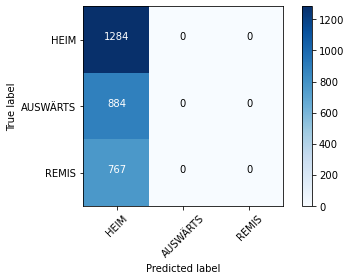

In [65]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['HEIM', 'AUSWÄRTS', 'REMIS'],
                      title='')

In [66]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

C:\Users\Anwender\AppData\Local\Temp/ipykernel_19532/1338496663.py:14: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
C:\Users\Anwender\AppData\Local\Temp/ipykernel_19532/1338496663.py:16: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN/(TN+FN)
C:\Users\Anwender\AppData\Local\Temp/ipykernel_19532/1338496663.py:22: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


In [67]:
#Genauigkeit
print(ACC)

[0.44 0.7  0.74]


In [68]:
#Präzision
print(PPV)

[0.44  nan  nan]


In [69]:
#Trefferquote
print(TPR)

[1. 0. 0.]


In [70]:
#F-Maß
F_SCORE= (2 * PPV * TPR)/(PPV+TPR)
print(F_SCORE)

[0.61  nan  nan]
